## Depth Inference

In [1]:
import os
import numpy as np
import pandas as pd
from time import sleep
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation

In [10]:
processor_depth = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model_depth = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

processor_mask = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-small-coco")
model_mask = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-coco")

d:\miniconda3\lib\site-packages\transformers\models\glpn\feature_extraction_glpn.py:28: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use GLPNImageProcessor instead.
  warnings.warn(
d:\miniconda3\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
d:\miniconda3\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [14]:
def get_depth(img):
    img = img.resize((512,512))
    inputs_d = processor_depth(img, return_tensors="pt").pixel_values

    import torch
    with torch.no_grad():
        outputs_d = model_depth(inputs_d)
        predicted_depth = outputs_d.predicted_depth
        predicted_depth.shape
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=inputs_d.shape[-2:],
                        mode="bicubic",
                        align_corners=False,
                )
    depth = prediction.squeeze().cpu().numpy()
    
    return depth

def get_mask(img):
    inputs_m = processor_mask(images=img, return_tensors="pt")
    outputs_m = model_mask(**inputs_m)
    predicted_semantic_map = processor_mask.post_process_semantic_segmentation(outputs_m, target_sizes=[img.size[::-1]])[0]

    return predicted_semantic_map

def get_nature_depth(img, label = None):
    #125:grass; 116:tree
    mask = get_mask(img)
    pre_depth = get_depth(img)
    
    mask = (np.array(mask) == label).astype(int) 
    # pre_depth_mask = (pre_depth * mask).reshape(-1) [(pre_depth * mask).reshape(-1) != 0]
    pre_depth_mask = (pre_depth * mask)  ##visual elements depth
    
    return pre_depth_mask
    # return mask

In [11]:
input_dir = "D:/···/samples"
output_file = "D:/···/depth.csv"

all_data = []
for image_path in tqdm(Path(input_dir).glob("*.jpg")):
    image = Image.open(image_path)
    image = image.resize((512, 512))

    depth = get_nature_depth(image, label=116)  # 125:grass; 116:tree

    # Append data to list of all data
    data = {"filename": image_path.name}
    if depth.size > 0:
        data["depth_mean"] = depth.mean()
    else:
        data["depth_mean"] = None
    
    if depth.size > 0:
        data["depth_max"] = depth.max()
    else:
        data["depth_max"] = None
        
    if depth.size > 0:
        data["depth_min"] = depth.min()
    else:
        data["depth_min"] = None
    
    all_data.append(data)

# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["depth_mean"] + ["depth_max"] + ["depth_min"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

0it [00:00, ?it/s]

200it [26:58,  8.09s/it]


In [7]:
# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["total_pixels"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

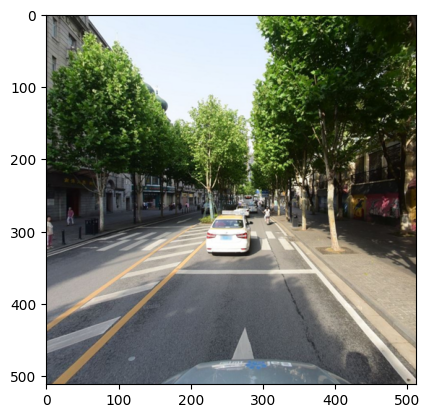

In [15]:
import matplotlib.pyplot as plt

# X = Image.open("D:/desk/test.jpg")
X = Image.open("D:/···/2023sample.png")

img = X.resize((512,512))
plt.imshow(img)

119 sky, 129 building, 100 road, 125 grass; 116 tree; 2 car

In [29]:
DEPTH = get_nature_depth(img, label=116)
DEPTH.mean()

3.663310415575512

In [30]:
DEPTH = get_nature_depth(img, label=125)
DEPTH.mean()

3.0996248622537843

In [1]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.7.4'

## OSL Analysis

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

# 读取 CSV 文件
data = pd.read_csv(r"D:\···\depth_wuhan_nor.csv")

X = data.iloc[:,4:] # 自变量x1和x2...
y = data.iloc[:,1] # 因变量y

# 运行OLS回归
model = sm.OLS(y, X).fit()

In [49]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          average_score   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                              172.9
Date:                 周二, 17 12月 2024   Prob (F-statistic):                        0.00
Time:                        10:59:08   Log-Likelihood:                          282.93
No. Observations:                1003   AIC:                                     -519.9
Df Residuals:                     980   BIC:                                     -406.9
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Model Training

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

In [9]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
data = pd.read_csv(r"D:\···\depth_wuhan.csv")

X = data.iloc[:,4:] # 自变量x1和x2...
y = data.iloc[:,1] # 因变量y

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
data.iloc[:,4:]

,grass_depth_mean,grass_depth_max,grass_depth_min,tree_depth_mean,tree_depth_max,tree_depth_min,building_seg,tree_seg,road_seg,sky_seg,...,grass_seg,car_obj,person_obj,truck_obj,motorcycle_obj,bicycle_obj,hue_mean,saturation_mean,light_mean,edge_mean
0,0.000000,0.000000,0.000000,1.246348,1.344793,1.063778,94.90,0.60,0.00,4.50,...,0.00,2,0,0.0,0,0,26.884162,76.485160,122.701981,23.226416
1,0.000000,0.000000,0.000000,1.714384,3.777097,1.197183,51.32,28.11,9.74,9.25,...,0.00,0,0,0.0,0,0,57.545314,56.652118,151.156774,20.365967
2,1.445940,1.882471,1.156380,2.399073,3.683363,1.376512,40.76,5.73,23.69,0.04,...,0.00,0,0,0.0,0,0,78.571248,48.699774,115.784871,26.668750
3,0.000000,0.000000,0.000000,3.535902,4.339160,1.886121,1.14,4.47,40.84,42.43,...,0.00,2,0,0.0,0,0,65.664473,27.873700,157.117471,14.147437
4,0.000000,0.000000,0.000000,1.854311,2.813763,1.130996,5.52,37.71,8.21,37.39,...,0.00,0,0,0.0,0,0,53.606549,63.246886,180.982399,31.430908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,1.470764,2.758047,1.068169,1.730085,2.870909,1.038563,37.73,22.00,19.98,1.32,...,2.31,2,0,0.0,0,0,41.069743,41.902619,165.003457,17.311279
999,0.000000,0.000000,0.000000,1.615234,2.262978,1.185080,28.40,8.54,17.35,35.64,...,0.00,4,0,0.0,0,0,77.338439,27.976297,154.093114,12.425854
1000,0.000000,0.000000,0.000000,1.633366,1.921543,1.293520,5.18,2.81,30.32,34.23,...,0.00,0,0,0.0,0,0,67.956789,49.017988,172.450547,19.587769
1001,0.000000,0.000000,0.000000,2.627186,5.323441,1.747522,8.94,1.49,14.70,44.33,...,0.00,4,0,0.0,0,0,76.327945,26.733095,197.362773,14.142318


In [26]:
## 归一化

from sklearn.preprocessing import MinMaxScaler

col_to_normalize = data.columns[1:]
print(col_to_normalize)

scaler = MinMaxScaler()
data[col_to_normalize] = scaler.fit_transform(data[col_to_normalize])
data.to_csv(r"D:\···\depth_wuhan_nor.csv", index = False)
print(data)

Index(['average_score', 'labels_three', 'label_average', 'grass_depth_mean',
       'grass_depth_max', 'grass_depth_min', 'tree_depth_mean',
       'tree_depth_max', 'tree_depth_min', 'building_seg', 'tree_seg',
       'road_seg', 'sky_seg', 'car_seg', 'plant_seg', 'van_seg',
       'sidewalk_seg', 'person_seg', 'bus_seg', 'fence_seg', 'grass_seg',
       'car_obj', 'person_obj', 'truck_obj', 'motorcycle_obj', 'bicycle_obj',
       'hue_mean', 'saturation_mean', 'light_mean', 'edge_mean'],
      dtype='object')
                             filename  average_score  labels_three  \
0     114.156143869_30.6128186974.png       0.000000           0.0   
1     114.158411111_30.6206021664.png       0.537575           0.5   
2       114.15942885_30.574736697.png       0.408682           0.5   
3     114.159630471_30.5788771409.png       0.558447           0.5   
4      114.15989869_30.6073719864.png       0.700706           1.0   
...                               ...            ...           

In [11]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 定义回归器
regressors = {
    "Linear SVM": SVR(kernel="linear", gamma=2, C=1),
    "Random Forest": RandomForestRegressor(max_depth=15, 
                                         n_estimators=5000, 
                                         random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, 
                                         random_state=42),
    "XGBoost": xgb.XGBRegressor(learning_rate=0.01,
                               n_estimators=5000,
                               max_depth=15,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=0.1,
                               random_state=42),
    # "GBDT": GradientBoostingRegressor(n_estimators=5000,
    #                                  learning_rate=0.01,
    #                                  max_depth=15,
    #                                  random_state=42),
    "Neural Net": MLPRegressor(alpha=1, 
                              learning_rate_init=0.001,
                              max_iter=5000, 
                              random_state=42)
}

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个模型在每个折叠上的性能
results = {name: {'RMSE': [], 'MSE': [], 'R2': []} for name in regressors.keys()}

# 对每个模型进行交叉验证
for name, model in regressors.items():
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # 分割数据
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 预测
        y_pred = model.predict(X_val)
        
        # 计算评估指标
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        
        # 存储结果
        results[name]['RMSE'].append(rmse)
        results[name]['MSE'].append(mse)
        # results[name]['R2'].append(r2)

# 计算平均性能指标
avg_results = {}
for name in results:
    avg_results[name] = {
        'RMSE': np.mean(results[name]['RMSE']),
        'MSE': np.mean(results[name]['MSE']),
        # 'R2': np.mean(results[name]['R2']),
        'RMSE_std': np.std(results[name]['RMSE']),
        'MSE_std': np.std(results[name]['MSE']),
        # 'R2_std': np.std(results[name]['R2'])
    }

# 将结果转换为DataFrame并打印
results_df = pd.DataFrame.from_dict(avg_results, orient='index')
print("\nAverage Model Performance (5-fold CV):")
print(results_df)


Average Model Performance (5-fold CV):
                   RMSE       MSE  RMSE_std   MSE_std
Linear SVM     0.188106  0.035427  0.006580  0.002476
Random Forest  0.180349  0.032616  0.009498  0.003405
Decision Tree  0.209683  0.044020  0.007307  0.003036
XGBoost        0.177124  0.031444  0.008468  0.003007
Neural Net     0.215804  0.046611  0.006275  0.002735


## Depth Validation


First few rows of the generated data:
   predict_grass_depth  human_grass_depth  predict_tree_depth  \
0             3.235718           2.113912            3.814128   
1             2.404512           1.500000            3.992910   
2             3.716353           2.987051            3.410755   
3             2.843674           1.770991            3.472778   
4             2.639706           2.530532            3.077304   

   human_tree_depth  
0          3.153325  
1          3.115873  
2          3.109848  
3          3.132208  
4          2.855469  


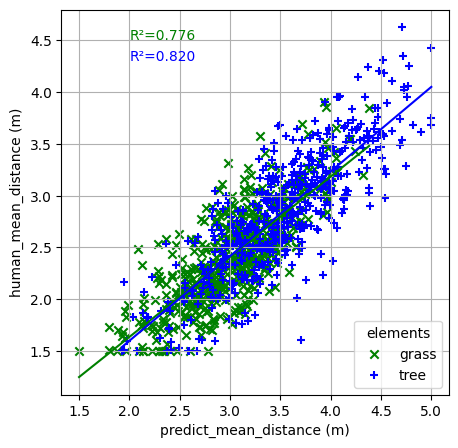

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 保存到CSV文件
df = pd.read_csv(r'D:\···\depth_samples.csv')

# 显示前几行数据
print("\nFirst few rows of the generated data:")
print(df.head())

# 创建图形
plt.figure(figsize=(5, 5))

# 绘制散点图和回归线
# 草地数据
grass = plt.scatter(df['predict_grass_depth'], df['human_grass_depth'], 
                   marker='x', color='green', label='grass')
z_grass = np.polyfit(df['predict_grass_depth'], df['human_grass_depth'], 1)
p_grass = np.poly1d(z_grass)
x_grass = np.linspace(df['predict_grass_depth'].min(), df['predict_grass_depth'].max(), 100)
plt.plot(x_grass, p_grass(x_grass), 'g-')

# 树木数据
tree = plt.scatter(df['predict_tree_depth'], df['human_tree_depth'], 
                  marker='+', color='blue', label='tree')
z_tree = np.polyfit(df['predict_tree_depth'], df['human_tree_depth'], 1)
p_tree = np.poly1d(z_tree)
x_tree = np.linspace(df['predict_tree_depth'].min(), df['predict_tree_depth'].max(), 100)
plt.plot(x_tree, p_tree(x_tree), 'b-')

# 计算相关系数
r2_grass = np.corrcoef(df['predict_grass_depth'], df['human_grass_depth'])[0,1]
r2_tree = np.corrcoef(df['predict_tree_depth'], df['human_tree_depth'])[0,1]

# 添加R²值到图例
plt.text(2, 4.5, f'R²={r2_grass:.3f}', color='green')
plt.text(2, 4.3, f'R²={r2_tree:.3f}', color='blue')

# 设置图形属性
plt.xlabel('predict_mean_distance (m)')
plt.ylabel('human_mean_distance (m)')
plt.grid(True)
plt.legend(title='elements', loc='lower right')

# 设置坐标轴范围
# plt.xlim(1.5, 5)
# plt.ylim(1.5, 5)

plt.show()

## Model Prediction

In [26]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
data = pd.read_csv(r"D:\···\revise\depth_wuhan_nor.csv")

X = data.iloc[:,4:] # 自变量x1和x2...
y = data.iloc[:,1] # 因变量y

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# y = scaler.fit_transform(np.array(y).reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
data.iloc[:,4:]

,grass_depth_mean,tree_depth_mean,building_seg,tree_seg,road_seg,sky_seg,bus_seg,car_obj,truck_obj,hue_mean,light_mean,edge_mean
0,0.000000,1.246348,0.9490,0.006027,0.000000,0.087942,0.000000,0.117647,0.0,0.158622,0.509291,0.342550
1,0.000000,1.714384,0.5132,0.282342,0.225672,0.180770,0.000000,0.000000,0.0,0.479558,0.644679,0.296148
2,1.445940,2.399073,0.4076,0.057553,0.548888,0.000782,0.031288,0.000000,0.0,0.699640,0.476380,0.398390
3,0.000000,3.535902,0.0114,0.044898,0.946247,0.829197,0.000000,0.117647,0.0,0.564542,0.673040,0.195273
4,0.000000,1.854311,0.0552,0.378767,0.190222,0.730702,0.000000,0.000000,0.0,0.438330,0.786590,0.475640
...,...,...,...,...,...,...,...,...,...,...,...,...
998,1.470764,1.730085,0.3773,0.220972,0.462929,0.025796,0.000000,0.117647,0.0,0.307105,0.710562,0.246596
999,0.000000,1.615234,0.2840,0.085777,0.401993,0.696502,0.042118,0.235294,0.0,0.686736,0.658650,0.167346
1000,0.000000,1.633366,0.0518,0.028224,0.702502,0.668947,0.000000,0.000000,0.0,0.588536,0.745995,0.283525
1001,0.000000,2.627186,0.0894,0.014966,0.340593,0.866328,0.000000,0.235294,0.0,0.676159,0.864528,0.195190


In [29]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

XGBoost version: 1.5.0


In [30]:
# -*- coding: utf-8 -*-
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import numpy as np
import pandas as pd

feature_names = X_train.columns.tolist()

# 确保X_train和y_train是numpy数组
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# 创建XGBoost回归模型
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror",
                          learning_rate=0.01,
                          n_estimators=5000, 
                          max_depth=15,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          reg_alpha=0.1,
                          reg_lambda=0.1,
                          random_state=50)

# 使用5折交叉验证
cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# 打印交叉验证分数
print("Cross-validation MSE scores: ", -cv_scores)
print("Mean MSE score: ", -cv_scores.mean())

# 训练模型
xgb_reg.fit(X_train, y_train)

# 预测
y_pred = xgb_reg.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('R2 Score:', r2)

Cross-validation MSE scores:  [0.0364399  0.02704661 0.03626882 0.02756367 0.03118108]
Mean MSE score:  0.031700017093661534
MSE: 0.03538484650620792
RMSE: 0.18810860295639836
R2 Score: 0.34288996293746965


In [47]:
# 从本地读取CSV文件并创建数据帧
data = pd.read_csv(r'D:\···\depth_wuhan_total.csv')

# 保存原始的自变量特征列
test_features = data.iloc[:,5:] 

# 数据标准化
scaler = MinMaxScaler()
test_features_scaled = scaler.fit_transform(test_features)

# 预测
predictions = xgb_reg.predict(test_features_scaled)

# 将预测结果添加到原始数据框中
data['Predictions'] = predictions

# 保存包含预测结果的完整数据框到新的CSV文件
data.to_csv(r'D:\···\depth_wuhan_total_with_predictions.csv', 
            index=False)

In [31]:
mybooster = xgb_reg.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

C:\Users\浩然\AppData\Local\Temp\ipykernel_33664\4229522425.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_melted,


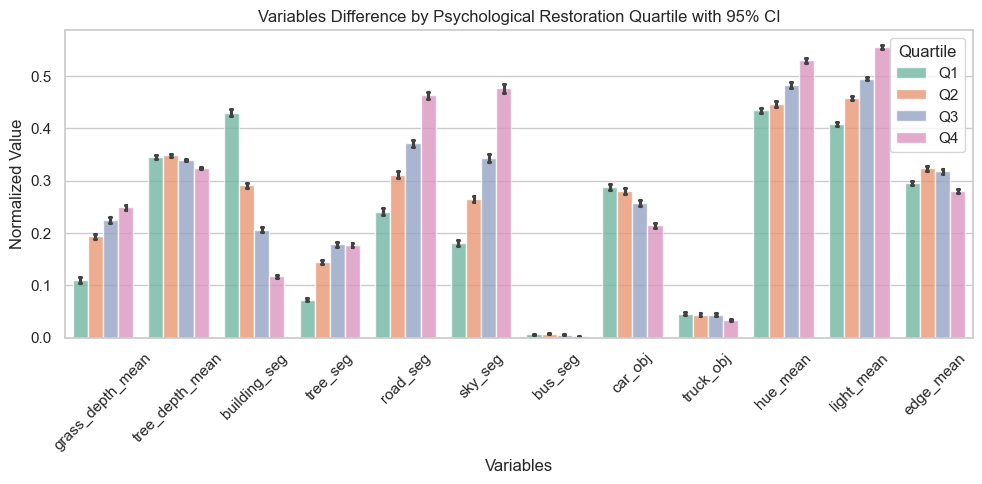


Statistical Summary by Quartile (Normalized):

grass_depth_mean:
            count  mean   std   min   25%   50%   75%   max
quartile                                                   
Q1       3944.000 0.110 0.172 0.000 0.000 0.000 0.234 0.919
Q2       3944.000 0.193 0.189 0.000 0.000 0.206 0.365 0.830
Q3       3943.000 0.224 0.182 0.000 0.000 0.260 0.380 1.000
Q4       3944.000 0.249 0.165 0.000 0.000 0.302 0.372 0.657

tree_depth_mean:
            count  mean   std   min   25%   50%   75%   max
quartile                                                   
Q1       3944.000 0.346 0.135 0.000 0.293 0.362 0.419 1.000
Q2       3944.000 0.349 0.090 0.000 0.297 0.355 0.406 0.845
Q3       3943.000 0.340 0.079 0.000 0.293 0.348 0.391 0.882
Q4       3944.000 0.324 0.070 0.000 0.280 0.330 0.371 0.610

building_seg:
            count  mean   std   min   25%   50%   75%   max
quartile                                                   
Q1       3944.000 0.429 0.220 0.000 0.281 0.399 0.573 1.000
Q

C:\Users\浩然\AppData\Local\Temp\ipykernel_33664\4229522425.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('quartile')[var].describe())
C:\Users\浩然\AppData\Local\Temp\ipykernel_33664\4229522425.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('quartile')[var].describe())
C:\Users\浩然\AppData\Local\Temp\ipykernel_33664\4229522425.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 读取数据
df = pd.read_csv(r'D:\···\depth_wuhan_total_with_predictions.csv')

# 根据predictions分为4个百分位
df['quartile'] = pd.qcut(df['Predictions'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# 需要比较的变量
# variables = ['grass_depth_mean', 'tree_depth_mean', 'building_seg', 'tree_seg', 
#             'road_seg', 'sky_seg']

# 需要比较的变量
variables = ['grass_depth_mean', 'tree_depth_mean', 'building_seg', 'tree_seg', 
            'road_seg', 'sky_seg', 'bus_seg', 'car_obj', 'truck_obj',
            'hue_mean', 'light_mean', 'edge_mean']

# 对变量进行归一化
scaler = MinMaxScaler()
df[variables] = scaler.fit_transform(df[variables])

# 将数据重塑为长格式
df_melted = pd.melt(df, 
                    id_vars=['quartile'],
                    value_vars=variables, 
                    var_name='Variable',
                    value_name='Value')

# 创建图形
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

# 绘制带有95%置信区间的条形图
sns.barplot(data=df_melted, 
           x='Variable', 
           y='Value', 
           hue='quartile',
           ci=95,
           capsize=.1,
           alpha=0.8,
           palette='Set2')

plt.xticks(rotation=45)
plt.title('Variables Difference by Psychological Restoration Quartile with 95% CI')
plt.xlabel('Variables')
plt.ylabel('Normalized Value')
plt.legend(title='Quartile')

plt.tight_layout()
plt.show()

# 打印归一化后的统计信息
print("\nStatistical Summary by Quartile (Normalized):")
for var in variables:
    print(f"\n{var}:")
    print(df.groupby('quartile')[var].describe())

In [49]:
import libpysal.weights as weights
import esda

def global_morans_i(df, column, k=5):
    coords = df[['lon', 'lat']].values
    knn = weights.KNN.from_array(coords, k=k)
    moran = esda.moran.Moran(df[column], knn)
    return moran

df = pd.read_csv(r'D:\···\depth_wuhan_total_with_predictions.csv')

moran = global_morans_i(df, 'tree_depth_mean', k=5)
print({'I': moran.I, 'p_value': moran.p_sim})

{'I': 0.2821435809843661, 'p_value': 0.001}


## SHAP Explain

In [32]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

In [34]:
explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(dtrain)

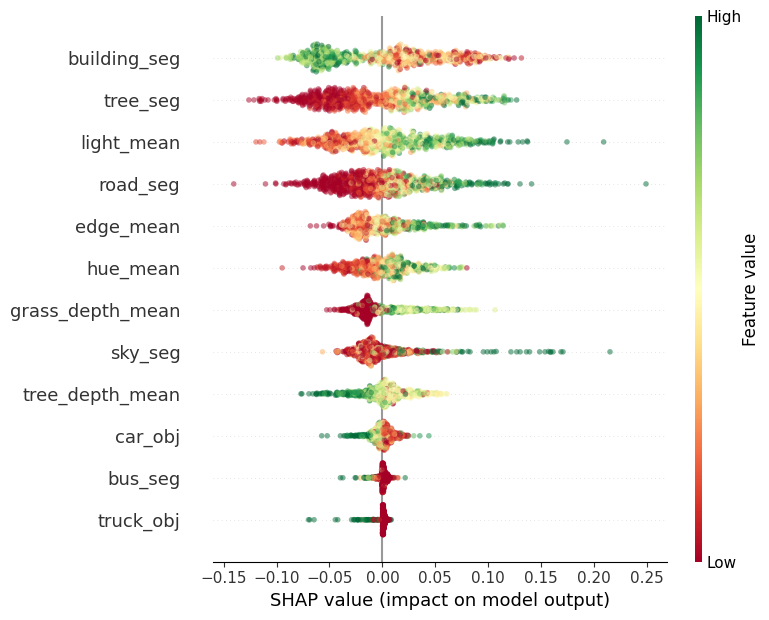

In [64]:
shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False, alpha=0.5, cmap="RdYlGn",)

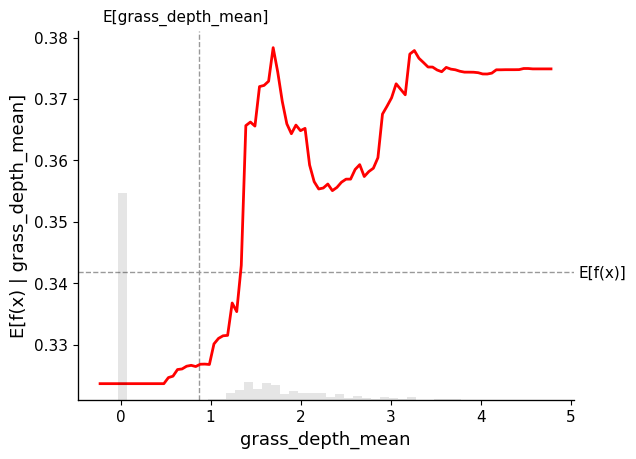

In [35]:
# 首先定义一个包装函数来处理预测
def model_predict(X):
    dmatrix = xgb.DMatrix(X, feature_names=feature_names)
    return mybooster.predict(dmatrix)

original_blue_rgb = shap.plots._partial_dependence.blue_rgb
shap.plots._partial_dependence.blue_rgb = '#FF0000'  # 或其他颜色

shap.plots.partial_dependence(
    ind=0,
    model=model_predict,
    data=X_train,
    feature_names=feature_names,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    pd_linewidth=2
)

shap.plots._partial_dependence.blue_rgb = original_blue_rgb

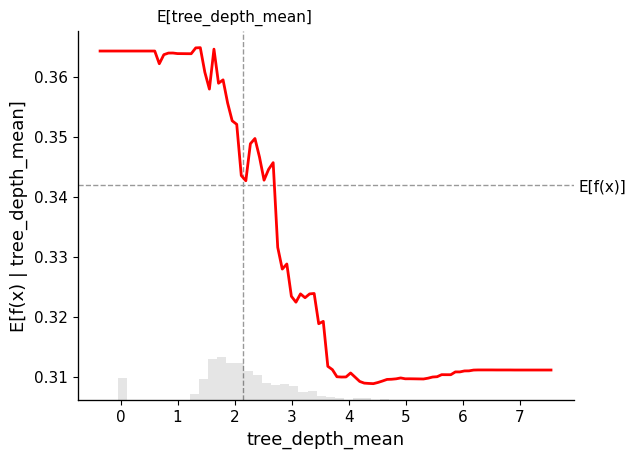

In [38]:
# 首先定义一个包装函数来处理预测
def model_predict(X):
    dmatrix = xgb.DMatrix(X, feature_names=feature_names)
    return mybooster.predict(dmatrix)

original_blue_rgb = shap.plots._partial_dependence.blue_rgb
shap.plots._partial_dependence.blue_rgb = '#FF0000'  # 或其他颜色

shap.plots.partial_dependence(
    ind=1,
    model=model_predict,
    data=X_train,
    feature_names=feature_names,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    pd_linewidth=2
)

shap.plots._partial_dependence.blue_rgb = original_blue_rgb

## Casual Inferece

In [50]:
import pandas as pd

df = pd.read_csv(r'D:···\depth_wuhan_nor.csv')
df.head(2)

,filename,average_score,labels_three,label_average,grass_depth_mean,tree_depth_mean,building_seg,tree_seg,road_seg,sky_seg,...,grass_seg,car_obj,person_obj,truck_obj,motorcycle_obj,bicycle_obj,hue_mean,saturation_mean,light_mean,edge_mean
0,114.156143869_30.6128186974.png,0.000,0.000,0,0.000,0.174,0.949,0.006,0.000,0.088,...,0.000,0.118,0.000,0.000,0.000,0.000,0.159,0.283,0.509,0.343
1,114.158411111_30.6206021664.png,0.538,0.500,1,0.000,0.239,0.513,0.282,0.226,0.181,...,0.000,0.000,0.000,0.000,0.000,0.000,0.480,0.195,0.645,0.296


In [26]:
df.describe().to_csv(r'D:\···\revise\sss.csv')

1882
914

Table: CATE of the treatments. The values were rounded to three significant figures.

        Treatment   ATE CI_Lower CI_Upper P_Value_Norm P_Value_Boot P_Value_Ttest P_Value_Wilcoxon
 tree_depth_mean 0.093    0.087    0.099        0.000        0.000         0.000            0.000
grass_depth_mean 0.034    0.031    0.038        0.000        0.000         0.000            0.000

 Significance levels: *** p<0.01, ** p<0.05, * p<0.1
Different p-values represent different statistical tests.


C:\Users\浩然\AppData\Local\Temp\ipykernel_33664\2436653490.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, widths=0.2)


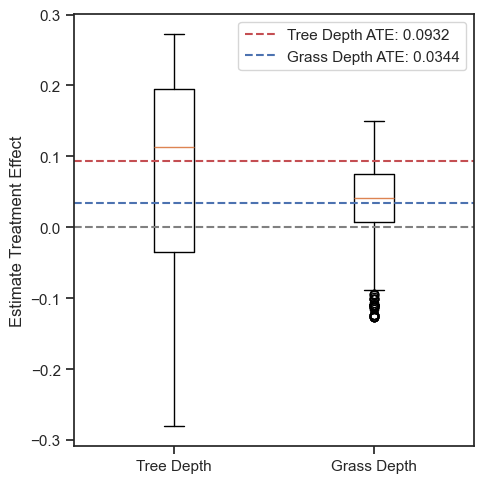

In [53]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from econml.grf import CausalForest
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from econml.grf import CausalForest
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def bootstrap_significance(te_pred, treatment_name, n_bootstrap=1000, alpha=0.05):
    # 确保te_pred是numpy数组
    te_pred = np.array(te_pred).flatten()
    
    # Calculate point estimate
    ate = np.mean(te_pred)
    
    # Bootstrap confidence intervals
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(te_pred), len(te_pred))
        bootstrap_sample = te_pred[indices]
        bootstrap_estimates.append(np.mean(bootstrap_sample))
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    
    # 1. 标准正态分布p值
    std_error = np.std(bootstrap_estimates)
    t_stat = ate / std_error
    p_value_norm = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    # 2. Bootstrap percentile p值
    p_value_boot = min(
        2 * min(
            np.mean(bootstrap_estimates <= 0),
            np.mean(bootstrap_estimates >= 0)
        ),
        1.0
    )
    
    # 3. Student's t-test p值
    t_stat_raw, p_value_ttest = stats.ttest_1samp(te_pred, 0)
    
    # 4. Wilcoxon signed-rank test p值
    _, p_value_wilcoxon = stats.wilcoxon(te_pred)
    
    # Prepare results
    results = pd.DataFrame({
        'Treatment': [treatment_name],
        'ATE': [f"{ate:.3f}"],
        'CI_Lower': [f"{ci_lower:.3f}"],
        'CI_Upper': [f"{ci_upper:.3f}"],
        'P_Value_Norm': [f"{p_value_norm:.3f}"],
        'P_Value_Boot': [f"{p_value_boot:.3f}"],
        'P_Value_Ttest': [f"{p_value_ttest:.3f}"],
        'P_Value_Wilcoxon': [f"{p_value_wilcoxon:.3f}"]
    })
    
    # 使用bootstrap p值来确定显著性星号
    p_value = p_value_boot  # 可以选择使用其他p值
    
    if p_value < 0.01:
        sig_level = "***"
    elif p_value < 0.05:
        sig_level = "**"
    elif p_value < 0.1:
        sig_level = "*"
    else:
        sig_level = ""
    
    note = (f"Significance levels: *** p<0.01, ** p<0.05, * p<0.1\n"
            f"Different p-values represent different statistical tests.")
    
    return results, note

# def bootstrap_significance(te_pred, treatment_name, n_bootstrap=1000, alpha=0.05):
#     # Calculate point estimate
#     ate = np.mean(te_pred)
    
#     # Bootstrap confidence intervals
#     bootstrap_estimates = []
#     for _ in range(n_bootstrap):
#         indices = np.random.randint(0, len(te_pred), len(te_pred))
#         bootstrap_sample = te_pred[indices]
#         bootstrap_estimates.append(np.mean(bootstrap_sample))
    
#     # Calculate confidence intervals
#     ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
#     ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    
#     # Calculate p-value
#     std_error = np.std(bootstrap_estimates)
#     t_stat = ate / std_error
#     p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
#     # Prepare results
#     results = pd.DataFrame({
#         'Treatment': [treatment_name],
#         'ATE': [f"{ate:.3f}"],
#         'CI_Lower': [f"{ci_lower:.3f}"],
#         'CI_Upper': [f"{ci_upper:.3f}"],
#         'P_Value': [f"{p_value:.3f}"]
#     })
    
#     # Prepare significance note
#     if p_value < 0.01:
#         sig_level = "***"
#     elif p_value < 0.05:
#         sig_level = "**"
#     elif p_value < 0.1:
#         sig_level = "*"
#     else:
#         sig_level = ""
    
#     note = f"Significance levels: *** p<0.01, ** p<0.05, * p<0.1"
    
#     return results, note

def propensity_score_matching(X, T, k=1):
    """
    进行倾向性评分匹配
    """
    # 计算倾向性评分
    propensity = LogisticRegression(random_state=42).fit(X, T)
    propensity_scores = propensity.predict_proba(X)[:, 1]
    
    # 使用最近邻匹配
    treated = np.where(T == 1)[0]
    control = np.where(T == 0)[0]
    
    # 为处理组和对照组分别构建最近邻模型
    nbrs_treated = NearestNeighbors(n_neighbors=k).fit(propensity_scores[treated].reshape(-1, 1))
    nbrs_control = NearestNeighbors(n_neighbors=k).fit(propensity_scores[control].reshape(-1, 1))
    
    # 找到匹配的样本
    matches_treated = nbrs_control.kneighbors(propensity_scores[treated].reshape(-1, 1))[1]
    matches_control = nbrs_treated.kneighbors(propensity_scores[control].reshape(-1, 1))[1]
    
    # 获取匹配的索引
    matched_indices = np.concatenate([treated, control[matches_treated.ravel()]])
    
    return matched_indices

def analyze_treatment(df, treatment_var, feature_cols):
    # 数据准备
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df[feature_cols].values)
    Y = df['average_score'].values
    T = (df[treatment_var] > 0).astype(int).values
    
    # 倾向性评分匹配
    matched_indices = propensity_score_matching(X, T)
    
    # 使用匹配后的样本
    X_matched = X[matched_indices]
    T_matched = T[matched_indices]
    Y_matched = Y[matched_indices]
    print(len(T_matched))
    
    # 运行因果森林分析
    cf = CausalForest(n_estimators=200,
                      min_samples_leaf=5,
                      max_depth=None,
                      random_state=42)
    
    cf.fit(X_matched, T_matched, Y_matched)
    te_pred = cf.predict(X_matched)
    
    # 计算显著性
    results, note = bootstrap_significance(te_pred, treatment_var, n_bootstrap=1000)
    
    return {
        'sample_size': len(T_matched),
        'ate': np.mean(te_pred),
        'te_pred': te_pred,
        'results': results,
        'note': note
    }

# 分析两个treatment变量
treatments = ['tree_depth_mean', 'grass_depth_mean']
results_dict = {}

feature_cols = ['building_seg',	'tree_seg',	'road_seg',	'sky_seg',	
                'car_seg',	'plant_seg',	'van_seg',	'sidewalk_seg',	
                'person_seg',	'bus_seg',	'fence_seg',	'grass_seg',	
                'car_obj',	'person_obj',	'truck_obj',	'motorcycle_obj',	
                'bicycle_obj',	'hue_mean',	'saturation_mean',	'light_mean',	
                'edge_mean']

# feature_cols = ['grass_depth_mean',	'tree_depth_mean',	'building_seg',	
#                 'tree_seg',	'road_seg',	'sky_seg',	'bus_seg',	'car_obj',	
#                 'truck_obj',	'hue_mean',	'light_mean',	'edge_mean']

for treatment in treatments:
    results_dict[treatment] = analyze_treatment(df, treatment, feature_cols)

# 合并结果表格
combined_results = pd.concat([results_dict[t]['results'] for t in treatments])

# 打印结果
print("\nTable: CATE of the treatments. The values were rounded to three significant figures.")
print("\n", combined_results.to_string(index=False))
print("\n", results_dict[treatments[0]]['note'])


# 创建箱线图比较
plt.figure(figsize=(5, 5))
sns.set_theme(style="ticks")

box_data = [results_dict['tree_depth_mean']['te_pred'].flatten(), 
            results_dict['grass_depth_mean']['te_pred'].flatten()]
labels = ['Tree Depth', 'Grass Depth']
plt.boxplot(box_data, labels=labels, widths=0.2)
plt.axhline(y=0, color='gray', linestyle='--')

# 添加ATE标记线
colors = ['r', 'b']
for i, treatment in enumerate(['tree_depth_mean', 'grass_depth_mean']):
    ate = results_dict[treatment]['ate']
    plt.axhline(y=ate, color=colors[i], linestyle='--', 
                label=f'{labels[i]} ATE: {ate:.4f}')

plt.ylabel('Estimate Treatment Effect')
plt.legend()
plt.tight_layout()
plt.show()

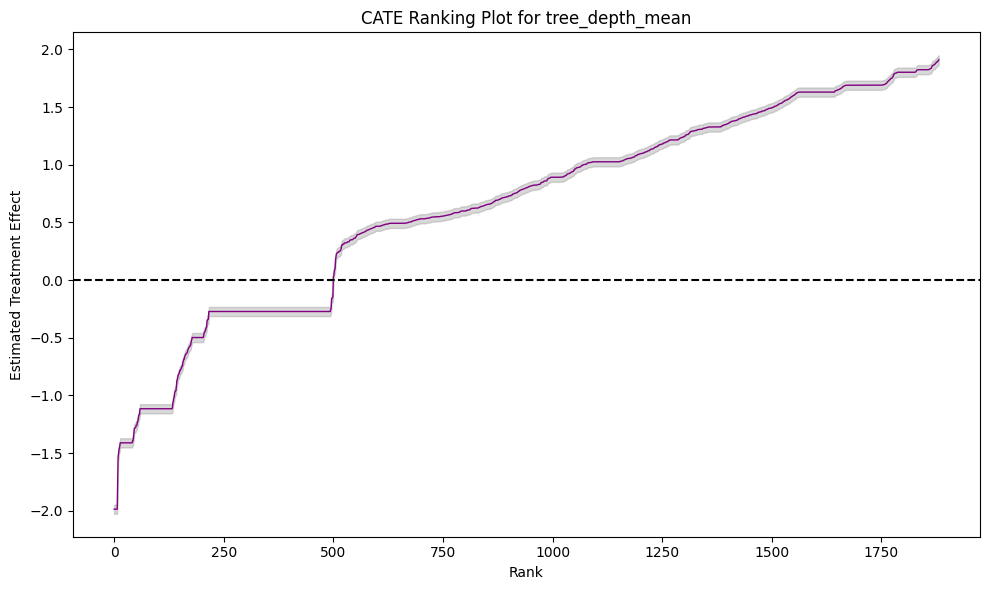

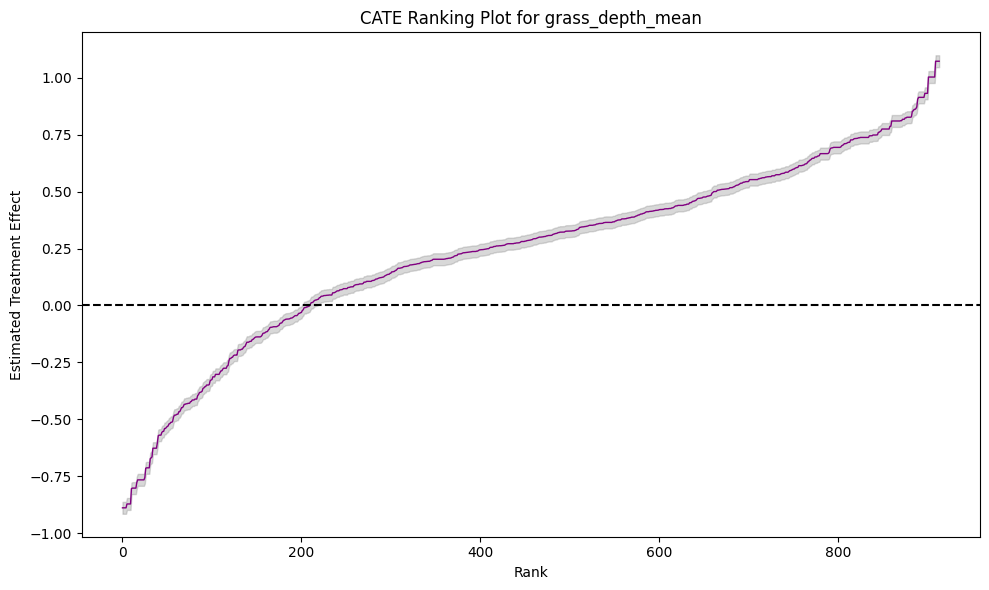

In [21]:
def plot_cate_ranking(te_pred, treatment_name):
    # 确保te_pred是一维数组
    te_pred = te_pred.flatten()
    
    # 对处理效应排序
    sorted_effects = np.sort(te_pred)
    ranks = np.arange(len(sorted_effects))
    
    # 计算置信区间
    ci_width = 1.96 * np.std(te_pred) / np.sqrt(len(te_pred))
    ci_lower = sorted_effects - ci_width
    ci_upper = sorted_effects + ci_width
    
    # 绘图
    plt.figure(figsize=(10, 6))
    
    # 绘制置信区间范围
    plt.fill_between(ranks, ci_lower, ci_upper, color='gray', alpha=0.3)
    
    # 绘制CATE估计值
    plt.plot(ranks, sorted_effects, 'purple', linewidth=1)
    
    # 添加零线
    plt.axhline(y=0, color='black', linestyle='--')
    
    # 设置标签和标题
    plt.xlabel('Rank')
    plt.ylabel('Estimated Treatment Effect')
    plt.title(f'CATE Ranking Plot for {treatment_name}')
    
    # 调整布局
    plt.tight_layout()
    plt.show()

# 对每个处理变量绘制图形
for treatment in treatments:
    te_pred = results_dict[treatment]['te_pred']
    plot_cate_ranking(te_pred, treatment)